In [3]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [4]:
def generate_dataset(n): 
    X = np.random.normal(size=(n, 10))
    X_sum = np.power(X, 2).sum(axis=1)
    Y = np.zeros(X_sum.shape)
    median = 9.34182
    Y[X_sum > median] = 1.0
    return X, Y 
x_train, y_train = generate_dataset(10000)
x_test, y_test = generate_dataset(2000)

- Implement your own version of bagging algorithm. You can use available implementations
of decision trees (or other base learners).

In [5]:
class Bagging: 
    def __init__(self, n_estimators=100): 
        self.n_estimators = n_estimators
        self.estimators = []
        self.errors = []
        self.test_errors = []
        
    def fit(self, x, y, x_test, y_test): 
        for estimator in range(self.n_estimators): 
            indices = np.random.choice(range(len(x)), size=y.shape)
            x_boot = x[indices]
            y_boot = y[indices]
            self.estimators.append(DecisionTreeClassifier().fit(x_boot, y_boot))
            self.evaluate(x, y, x_test, y_test)
        return self 
    
    def predict(self, x): 
        y_preds = [estimator.predict(x) for estimator in self.estimators]
        y_preds = sum(y_preds)
        return (y_preds > len(self.estimators)//2).astype(np.int32)
    
    def score(self, x, y):
        y_pred = self.predict(x)
        return accuracy_score(y, y_pred)
    
    def evaluate(self, x, y, x_test, y_test): 
        error_train = 1 - self.score(x, y)
        error_test = 1 - self.score(x_test, y_test)
        self.errors.append(error_train)
        self.test_errors.append(error_test)
        
    
model = Bagging()
model.fit(x_train, y_train, x_test, y_test)

In [6]:
model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.8695)

- Implement your own version of AdaBoost algorithm. You can use available implementations
of decision trees (or other base learners).

In [7]:
def one_hot(x):
    b = np.zeros((x.size, int(x.max()+1)))
    b[np.arange(x.size),x.astype(np.int32)] = 1
    return b
    

In [8]:
class AdaBoost: 
    def __init__(self, n_iters=100): 
        self.n_iters = n_iters
        self.estimators = []
        self.b_ks = []
        self.errors = []
        self.test_errors = []
        
    def fit(self, x, y, x_test, y_test): 
        weights = np.ones(y.shape)/len(x)
        for n_iter in range(self.n_iters): 
            self.estimators.append(DecisionTreeClassifier(max_depth=5)\
                                   .fit(x, y, sample_weight=weights))
            y_pred = self.estimators[-1].predict(x)
            e_k = ((y_pred != y).astype(np.int32) * weights).sum()
            b_k = e_k/(1-e_k)
            if e_k == 0 or e_k >= 0.5: 
                warnings.warn(f"e_k={e_k}, stopping AdaBoost on interation {n_iter} of {self.n_iters}")
                self.estimators = self.estimators[:-1]
                break
            weights[y_pred == y] = weights[y_pred == y]*b_k
            weights = weights/weights.sum()
            self.b_ks.append(b_k)
            
            self.evaluate(x, y, x_test, y_test) 
        return self 
    
    def predict(self, x): 
        y_preds = [one_hot(estimator.predict(x))*b_k for estimator, b_k in zip(self.estimators, self.b_ks)]
        y_preds = sum(y_preds)
        return np.argmax(y_preds, axis=1)
    
    def score(self, x, y):
        y_pred = self.predict(x)
        return accuracy_score(y, y_pred)
    
    def evaluate(self, x, y, x_test, y_test): 
        error_train = 1 - self.score(x, y)
        error_test = 1 - self.score(x_test, y_test)
        self.errors.append(error_train)
        self.test_errors.append(error_test)
        
        
model = AdaBoost()
model.fit(x_train, y_train, x_test, y_test)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9775, 0.938)

In [9]:
ada_model = AdaBoost(400)
ada_model.fit(x_train, y_train, x_test, y_test)

In [10]:
bag_model = Bagging(400)
bag_model.fit(x_train, y_train, x_test, y_test)

Bagging
AdaBoost
RandomForest
SingleTree
DecisionStump
GradientBoosting
[19:06:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\krystian kurek\.conda\envs\mgr\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<BarContainer object of 6 artists>

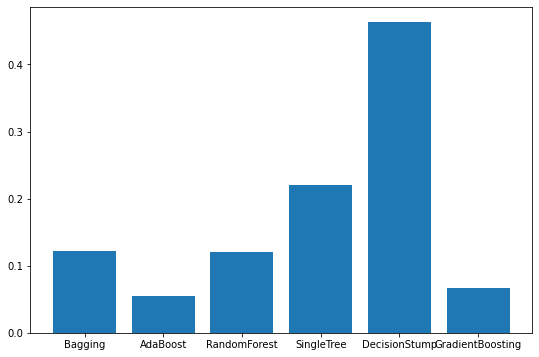

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))

classifiers = {'Bagging': Bagging,
                 'AdaBoost': AdaBoost,
                 'RandomForest': RandomForestClassifier, 
                'SingleTree': DecisionTreeClassifier,
                'DecisionStump': lambda : DecisionTreeClassifier(max_depth=1),
                'GradientBoosting': XGBClassifier}

classifier_names = []
classifier_errors = []
for classifier_name, classifier in classifiers.items(): 
    print(classifier_name)
    if classifier_name in {'Bagging', 'AdaBoost'}:
        model = classifier(400).fit(x_train, y_train, x_test, y_test)
    else: 
        model = classifier().fit(x_train, y_train)
    classifier_names.append(classifier_name)
    classifier_errors.append(1 - model.score(x_test, y_test))
plt.bar(classifier_names, classifier_errors)

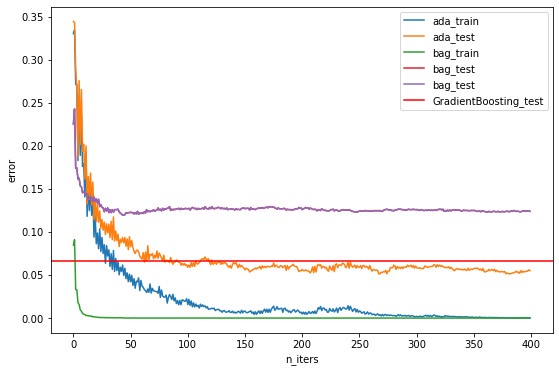

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(400), ada_model.errors, label='ada_train')
ax.plot(range(400), ada_model.test_errors, label='ada_test')
ax.plot(range(400), bag_model.errors, label='bag_train')
ax.plot(range(400), bag_model.test_errors, label='bag_test')
ax.plot(range(400), bag_model.test_errors, label='bag_test')
ax.axhline(y=classifier_errors[classifier_names.index('GradientBoosting')], color='r', linestyle='-', label='GradientBoosting_test')

ax.set_xlabel('n_iters')
ax.set_ylabel('error')
_ = ax.legend()